# Remove Abnormal Data from Training Set

Load DataFrame from `1_min/train.pkl`

Define multile functions that take a dataframe and return a boolean mask for entries to keep.

Combine masks in the end into a final mask, then it can be applied to `1_full` version as well if that's preferred.

In [1]:
import pandas as pd
import numpy as np
import os

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor

In [2]:
if ('my_home_path' not in os.environ) and ('MY_HOME_PATH' in os.environ):
    os.environ['my_home_path'] = os.environ['MY_HOME_PATH'] # because stupid :(

In [74]:
train_df = pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../1_min/train.pkl")

# total unique NORAD_IDs
# len(train_df.NORAD_CAT_ID.unique())

In [75]:
# np.random.choice(train_df.NORAD_CAT_ID.unique(),10)

In [76]:
# just using a small subset for testing
train_backup_df = train_df.copy()
# sample_ids = [12223, 26285, 10760, 14345, 34588, 330, 20970]
# sample_ids = [28974,36024,24403, 12223, 26285, 10760, 14345, 34588, 330, 20970, 35253, 38899, 36390, 27507, 31539,  8386,  6299, 18428, 17228, 42126]
sample_ids = [28974,36024,24403] # this is for arg of pericenter fails
sample_ids += list(np.random.choice(train_df.NORAD_CAT_ID.unique(),25))
train_df = train_backup_df[train_backup_df.NORAD_CAT_ID.isin(sample_ids)]

## Remove Erroneous Data
First we start by removing data which we don't want to include in our model.  This includes values which are outside of acceptable ranges or are physically impossible.

In [77]:
# Early TLEs are more prone to errors, cut off should be somewhere in the 80s
# TODO: putting in 1990 for now to be on the safe side

def more_recent_only(df):
    mask = df.EPOCH > "1990"
    return mask

In [78]:
# Space track LEO definition: Mean Motion > 11.25 and Eccentricity < 0.25
# This means that satellite that decay into LEO will not have non-LEO-like entries removed

def leo_check(df):
    mask = (df['MEAN_MOTION'] > 11.25) & (df['ECCENTRICITY'] < 0.25)
    return mask

In [79]:
# valid range for 'RA_OF_ASC_NODE', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY' is 0..360

def degrees_range_check(df):
    degree_columns = ['RA_OF_ASC_NODE', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY']
    mask = df[degree_columns].apply(lambda x:x.between(0,360), axis=0).all(axis=1)
    return mask

In [80]:
# valid INCLINATION range is 0..180

def inclination_range_check(df):
    mask = df['INCLINATION'].between(0,180)
    return mask

In [81]:
# TODO: Anything beyond 20 should be outliers... I think...
# > 16.5 you do get multiple entries from the same satellite, so those shouldn't be outliers
# train_df[train_df['MEAN_MOTION'] > 16.5].NORAD_CAT_ID.value_counts()    

def mean_motion_range_check(df):
    mask = df['MEAN_MOTION'].between(11.25,20)
    return mask

In [82]:
# Skipping first few entries may be a good idea due to initial readings being less accurate (?)
# TODO: using N=5 for now
# this one takes longer because of the grouping

def skip_first_n(df, n=5):
    mask = df.groupby(by="NORAD_CAT_ID", as_index=False).apply(lambda x:x.EPOCH.rank() > n).reset_index(level=0, drop=True).sort_index()
    return mask

In [83]:
anomaly_functions = [
    more_recent_only,
    leo_check,
    degrees_range_check,
    inclination_range_check,
    mean_motion_range_check,
    skip_first_n,
]

anomaly_results = []
for fn in tqdm(anomaly_functions):
    print(f"Processing function: \"{fn.__name__}\"")
    %time res = fn(train_df)
    print("==========================================================")
    res.name = fn.__name__
    anomaly_results.append(res)

  0%|          | 0/6 [00:00<?, ?it/s]

Processing function: "more_recent_only"
CPU times: user 2.69 ms, sys: 0 ns, total: 2.69 ms
Wall time: 2.1 ms
Processing function: "leo_check"
CPU times: user 2.59 ms, sys: 806 µs, total: 3.39 ms
Wall time: 1.56 ms
Processing function: "degrees_range_check"
CPU times: user 9.19 ms, sys: 606 µs, total: 9.8 ms
Wall time: 5.23 ms
Processing function: "inclination_range_check"
CPU times: user 1.72 ms, sys: 868 µs, total: 2.59 ms
Wall time: 1.03 ms
Processing function: "mean_motion_range_check"
CPU times: user 1.7 ms, sys: 860 µs, total: 2.56 ms
Wall time: 1.01 ms
Processing function: "skip_first_n"
CPU times: user 52.6 ms, sys: 4.42 ms, total: 57 ms
Wall time: 55.1 ms


In [84]:
# mask results

for s in anomaly_results:
    display(s.value_counts())
    
combined = pd.concat(anomaly_results, axis=1).all(axis=1)
combined.name = "combined_masks"
print("==========================================================\nMasks combined:")
display(combined.value_counts())

True     97377
False     5683
Name: more_recent_only, dtype: int64

True     101997
False      1063
Name: leo_check, dtype: int64

True    103060
Name: degrees_range_check, dtype: int64

True    103060
Name: inclination_range_check, dtype: int64

True     101997
False      1063
Name: mean_motion_range_check, dtype: int64

True     102921
False       139
Name: skip_first_n, dtype: int64

Masks combined:


True     96210
False     6850
Name: combined_masks, dtype: int64

## Generate a new DataFrame for Outliers

Masked version of DataFrame for unsupervised learning outlier detection

In [85]:
masked_df = train_df[combined]
# masked_sample_df = masked_df[masked_df.NORAD_CAT_ID.isin(sample_ids)]

## Use Unsupervised Learning to Remove Outliers

We'll be using `DBSCAN`

In [86]:
# testing DBSCAN

from sklearn.cluster import DBSCAN

def dbscan_removal(df, debug=False):
#     columns = ["INCLINATION","ECCENTRICITY","MEAN_MOTION"]
    # mean motion turns out to be not very good, due to the final decay as well as outliers reflected in other fields as well
    columns = ["INCLINATION","ECCENTRICITY","ARG_OF_PERICENTER","RA_OF_ASC_NODE"]

    def detect_outliers(input_df):
        name = input_df.name
        dbscan_min_samples = max(len(input_df)/100, 20)
        
        sub_df = input_df.set_index('EPOCH', append=True).sort_index(level=1)
        outlier_labels = []
        for i,column in enumerate(columns):
            if column in ["ARG_OF_PERICENTER","RA_OF_ASC_NODE"]:
                c_diff = sub_df[column].diff(-1)
                c_diff_adj = np.minimum(np.abs(c_diff), 360-np.abs(c_diff))
                c_diff = c_diff_adj * np.sign(c_diff)
                col_diff = np.minimum(c_diff.diff()**2, c_diff.diff(-1)**2).fillna(0) + np.minimum(c_diff.diff(2)**2, c_diff.diff(-2)**2).fillna(0)
                dbscan_eps = col_diff.std()*1
                if not dbscan_eps > 0.0: # should never or rarely happen, but has happened before....
                    dbscan_eps = 1 # arbitary, which should mean no outliers for this satellite
                    dbscan_eps_zero_neg.append(name) # keep track of it

                db = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples).fit(col_diff.to_frame())
            else:
                col_diff = np.minimum(sub_df[column].diff()**2, sub_df[column].diff(-1)**2).fillna(0) + np.minimum(sub_df[column].diff(2)**2, sub_df[column].diff(-2)**2).fillna(0)
                dbscan_eps = col_diff.std()*3
                if not dbscan_eps > 0.0: # should never or rarely happen, but has happened before....
                    dbscan_eps = 1 # arbitary, which should mean no outliers for this satellite
                    dbscan_eps_zero_neg.append(name) # keep track of it

                db = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples).fit(col_diff.to_frame())
            core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_
            # Number of clusters in labels, ignoring noise if present.
            outlier_labels.append(labels)

        all_normal = (np.array(outlier_labels).T.min(axis=1) != -1)

        normal_data = sub_df[all_normal]

        if debug:
            print(f"=============================\nnorad id: {name}, rows:{len(input_df)}")
            ax = (sub_df[columns].droplevel(0)).plot(subplots=True,figsize=(20,6));
            outlier_data = sub_df[~all_normal]
            num_all_outliers = len(input_df)-np.sum(all_normal)
#             display(outlier_data)
            for i,column in enumerate(columns):
                column_outliers = sub_df[outlier_labels[i] == -1]
#                 print(column_outliers)
                labels = outlier_labels[i]
                n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
                n_noise_ = list(labels).count(-1)    
                print(f"column: {column}, n_clusters_: {n_clusters_}, n_noise_: {n_noise_}, noise %:{n_noise_/len(input_df):.5f}%")
                ax[i].scatter(outlier_data.index.get_level_values(1), outlier_data[column], s=40, color="red", alpha=1, marker="x", zorder=-1)
    #             ax[i].set_title=f"{column} #clusters: {n_clusters_}, #noise: {n_noise_}, noise %:{n_noise_/len(input_df):.5f}%"
#                 ax[i].set_title=f"AAAAAA"
                ax[i].scatter(column_outliers.index.get_level_values(1), column_outliers[column], s=40, color="black", alpha=1, marker="x", zorder=0)
            ax[-1].figure.suptitle(f"combined noise: {num_all_outliers}, noise %:{num_all_outliers/len(input_df):.5f}%")
            print(f"norad id: {name}, rows:{len(input_df)}, combined noise count: {num_all_outliers}, noise %:{num_all_outliers/len(input_df):.5f}%")
            print(f"last 30 {all_normal[-30:].astype(int)}")
            plt.show()
        
        # should just return boolean mask with index from input
        return pd.Series(all_normal.astype(bool), index=sub_df.index)
    
    # combine mask from each group then reset, sort, etc.
    return df.groupby(by="NORAD_CAT_ID", as_index=False).progress_apply(detect_outliers).droplevel([0,2]).sort_index()

  0%|          | 0/25 [00:00<?, ?it/s]

norad id: 407, rows:15371
column: INCLINATION, n_clusters_: 1, n_noise_: 32, noise %:0.00208%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 34, noise %:0.00221%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 52, noise %:0.00338%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 43, noise %:0.00280%
norad id: 407, rows:15371, combined noise count: 123, noise %:0.00800%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


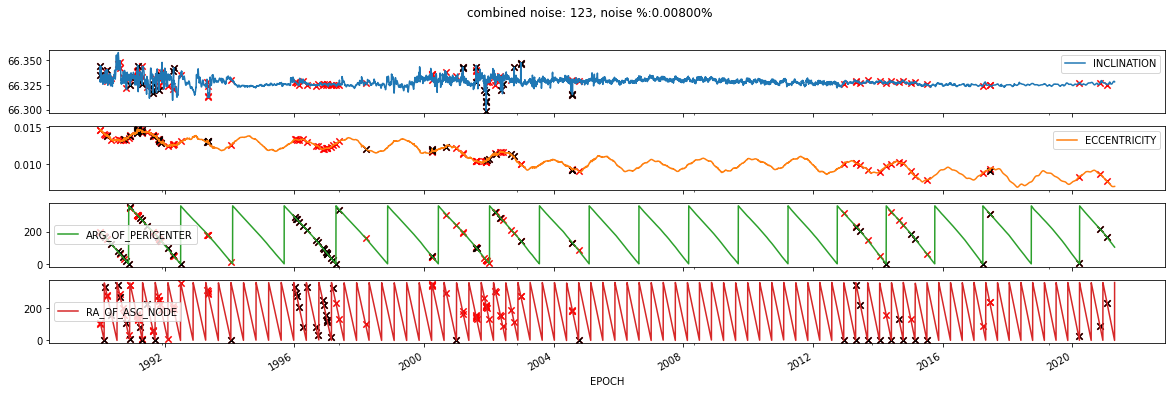

norad id: 5826, rows:12327
column: INCLINATION, n_clusters_: 1, n_noise_: 9, noise %:0.00073%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 9, noise %:0.00073%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 57, noise %:0.00462%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 52, noise %:0.00422%
norad id: 5826, rows:12327, combined noise count: 85, noise %:0.00690%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


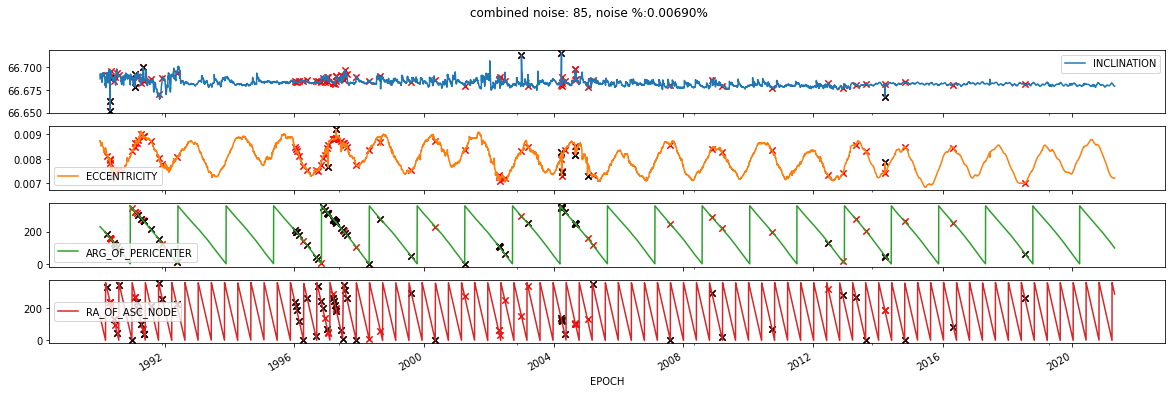

norad id: 10833, rows:13815
column: INCLINATION, n_clusters_: 1, n_noise_: 20, noise %:0.00145%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 25, noise %:0.00181%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 108, noise %:0.00782%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 53, noise %:0.00384%
norad id: 10833, rows:13815, combined noise count: 152, noise %:0.01100%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


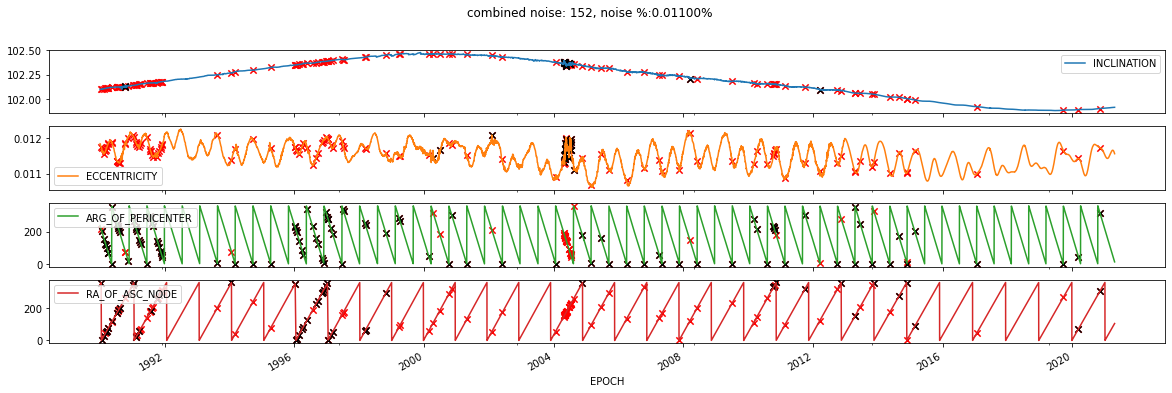

norad id: 22468, rows:12236
column: INCLINATION, n_clusters_: 1, n_noise_: 22, noise %:0.00180%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 26, noise %:0.00212%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 45, noise %:0.00368%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 40, noise %:0.00327%
norad id: 22468, rows:12236, combined noise count: 102, noise %:0.00834%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


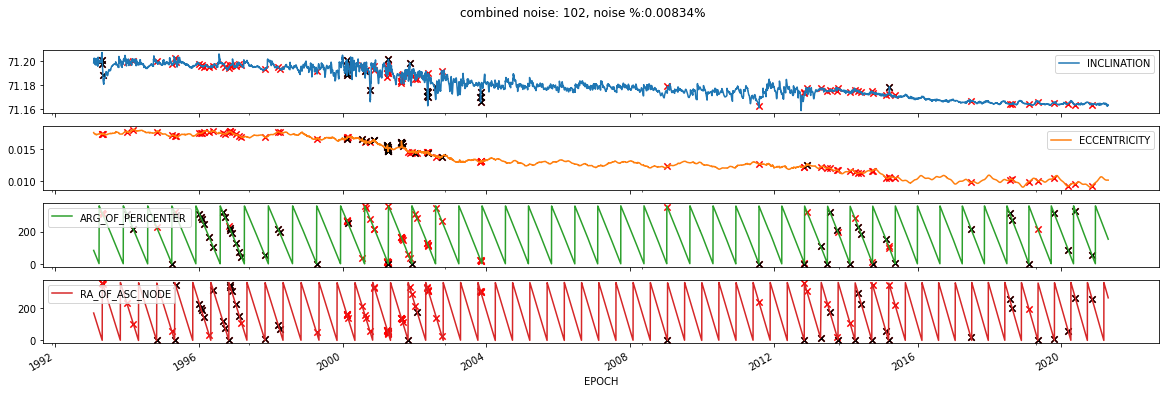

norad id: 22841, rows:10871
column: INCLINATION, n_clusters_: 1, n_noise_: 27, noise %:0.00248%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 20, noise %:0.00184%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 24, noise %:0.00221%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 22, noise %:0.00202%
norad id: 22841, rows:10871, combined noise count: 67, noise %:0.00616%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


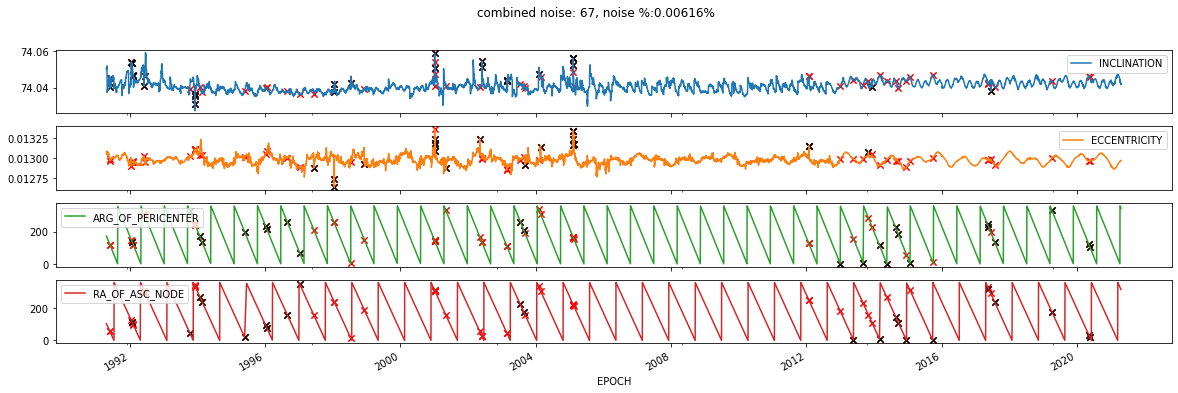

norad id: 22914, rows:54
column: INCLINATION, n_clusters_: 1, n_noise_: 1, noise %:0.01852%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 1, noise %:0.01852%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 3, noise %:0.05556%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 1, noise %:0.01852%
norad id: 22914, rows:54, combined noise count: 4, noise %:0.07407%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


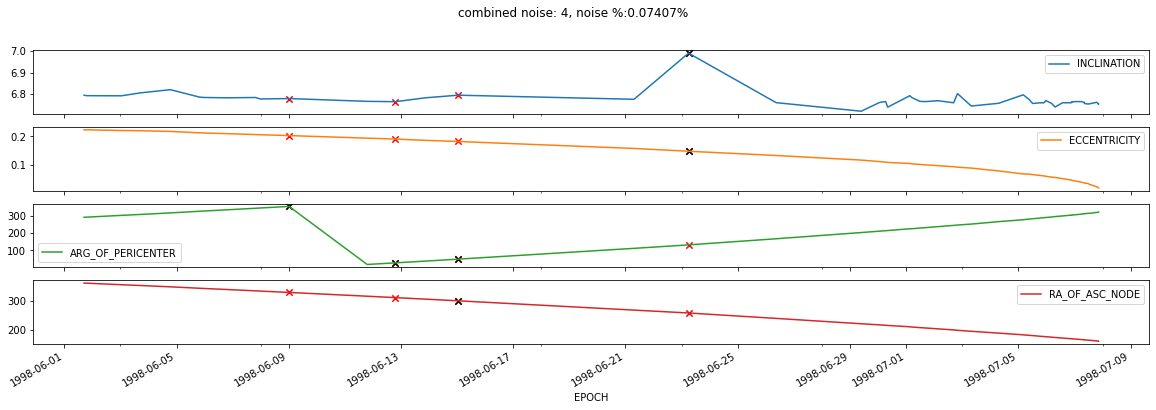

norad id: 24403, rows:528
column: INCLINATION, n_clusters_: 1, n_noise_: 4, noise %:0.00758%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 3, noise %:0.00568%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 6, noise %:0.01136%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 9, noise %:0.01705%
norad id: 24403, rows:528, combined noise count: 18, noise %:0.03409%
last 30 [1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1]


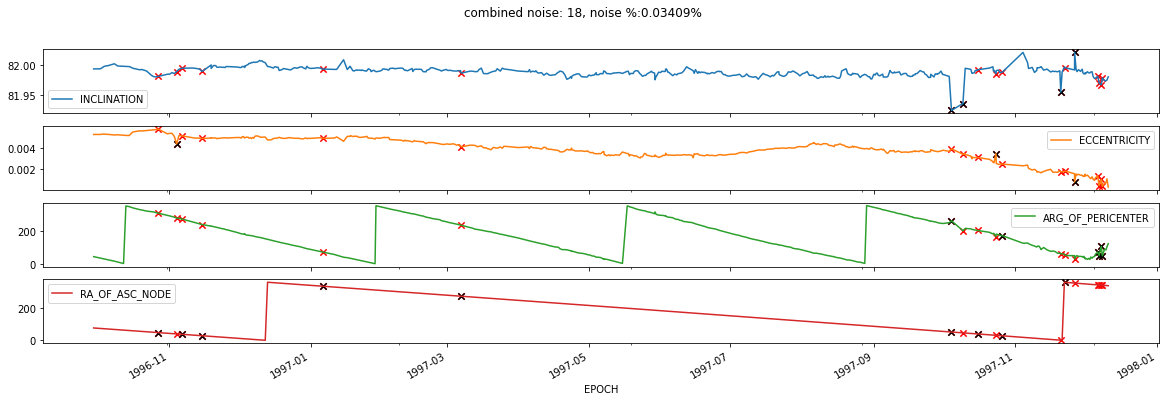

norad id: 24857, rows:151
column: INCLINATION, n_clusters_: 1, n_noise_: 1, noise %:0.00662%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 2, noise %:0.01325%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 1, noise %:0.00662%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 2, noise %:0.01325%
norad id: 24857, rows:151, combined noise count: 5, noise %:0.03311%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]


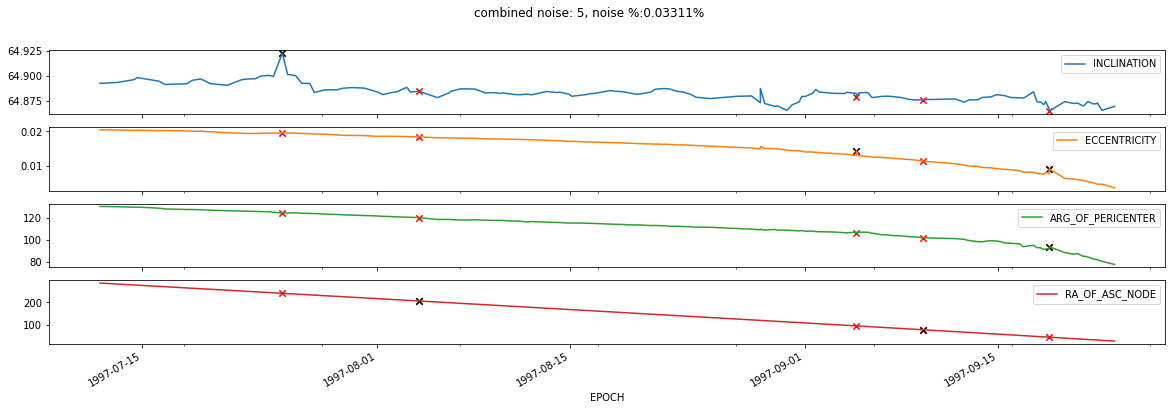

norad id: 28974, rows:2792
column: INCLINATION, n_clusters_: 1, n_noise_: 3, noise %:0.00107%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 7, noise %:0.00251%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 25, noise %:0.00895%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 23, noise %:0.00824%
norad id: 28974, rows:2792, combined noise count: 44, noise %:0.01576%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


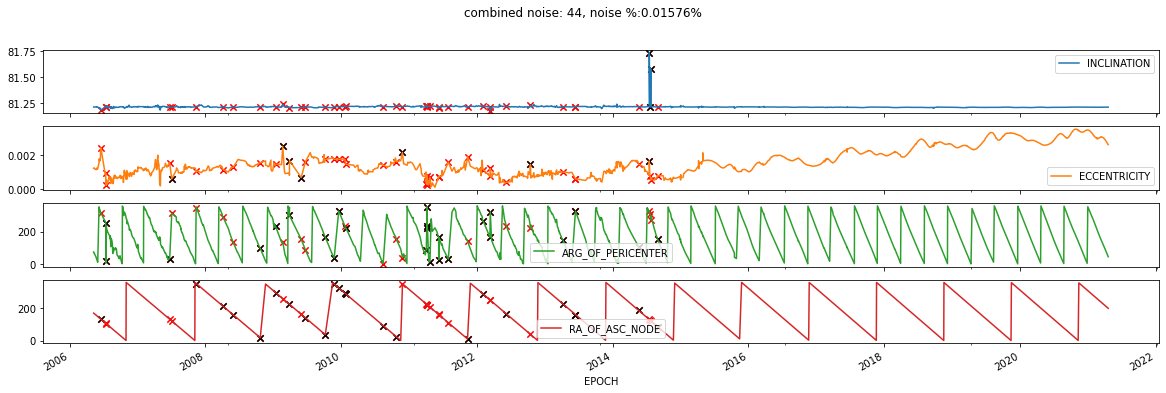

norad id: 29807, rows:6606
column: INCLINATION, n_clusters_: 1, n_noise_: 6, noise %:0.00091%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 6, noise %:0.00091%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 28, noise %:0.00424%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 22, noise %:0.00333%
norad id: 29807, rows:6606, combined noise count: 46, noise %:0.00696%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


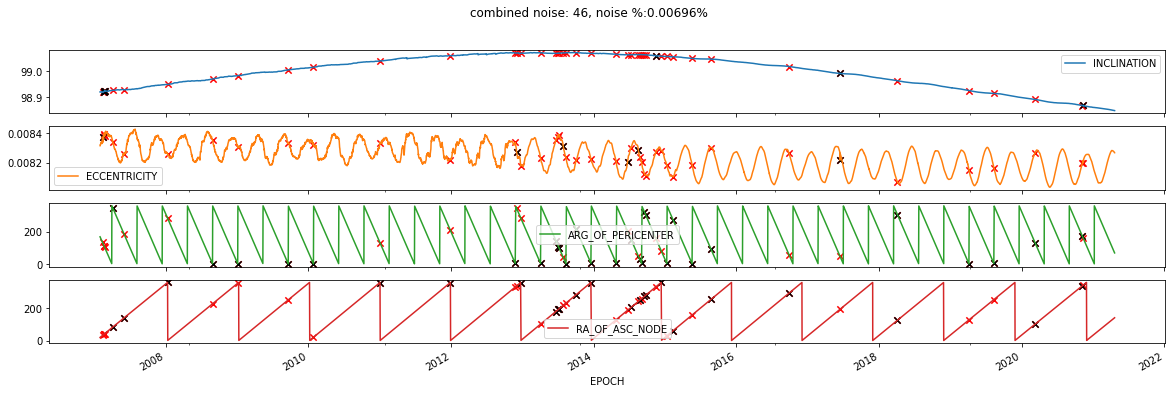

norad id: 31682, rows:1735
column: INCLINATION, n_clusters_: 1, n_noise_: 6, noise %:0.00346%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 1, noise %:0.00058%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 13, noise %:0.00749%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 7, noise %:0.00403%
norad id: 31682, rows:1735, combined noise count: 19, noise %:0.01095%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


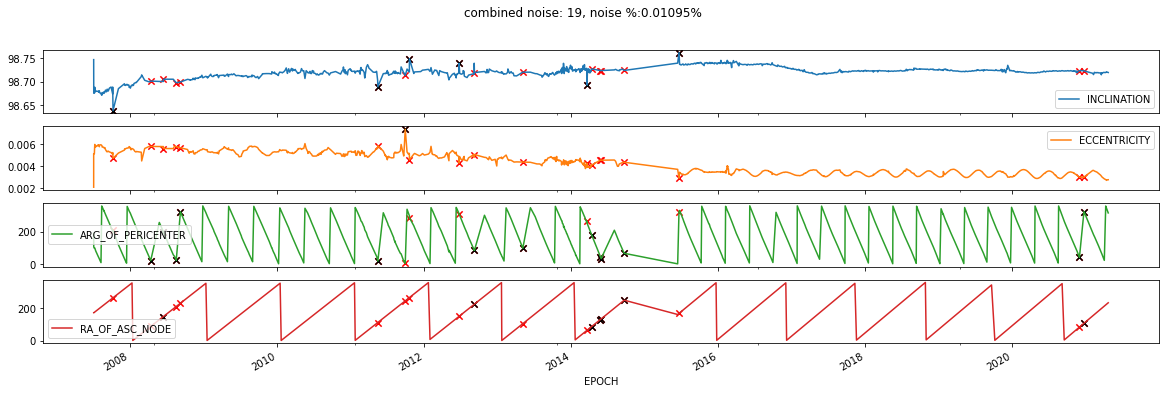

norad id: 32746, rows:29
column: INCLINATION, n_clusters_: 1, n_noise_: 0, noise %:0.00000%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 0, noise %:0.00000%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 1, noise %:0.03448%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 4, noise %:0.13793%
norad id: 32746, rows:29, combined noise count: 4, noise %:0.13793%
last 30 [1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]


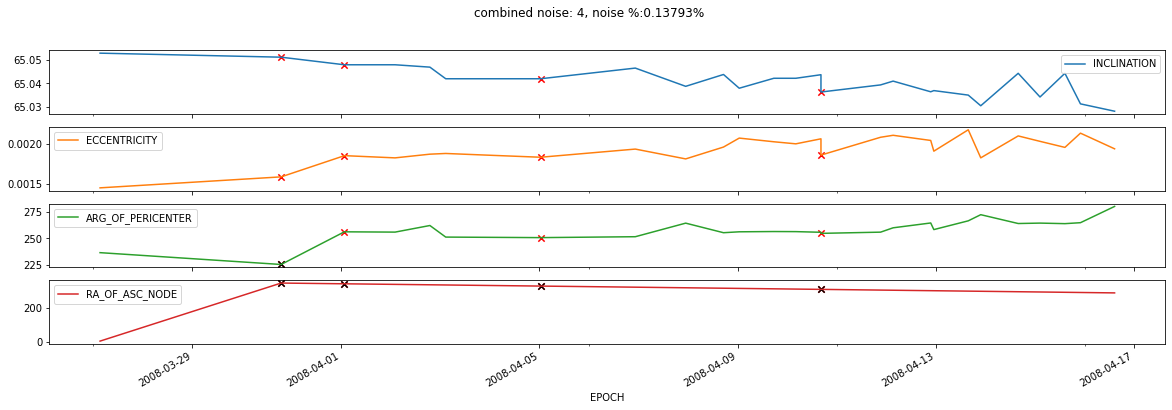

norad id: 33175, rows:234
column: INCLINATION, n_clusters_: 1, n_noise_: 1, noise %:0.00427%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 2, noise %:0.00855%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 6, noise %:0.02564%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 3, noise %:0.01282%
norad id: 33175, rows:234, combined noise count: 10, noise %:0.04274%
last 30 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1]


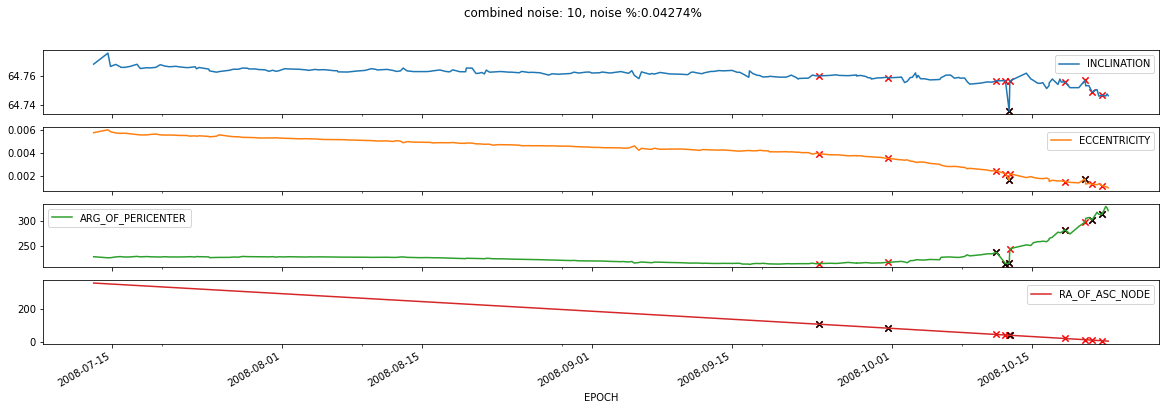

norad id: 33732, rows:131
column: INCLINATION, n_clusters_: 1, n_noise_: 1, noise %:0.00763%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 2, noise %:0.01527%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 3, noise %:0.02290%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 5, noise %:0.03817%
norad id: 33732, rows:131, combined noise count: 8, noise %:0.06107%
last 30 [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1]


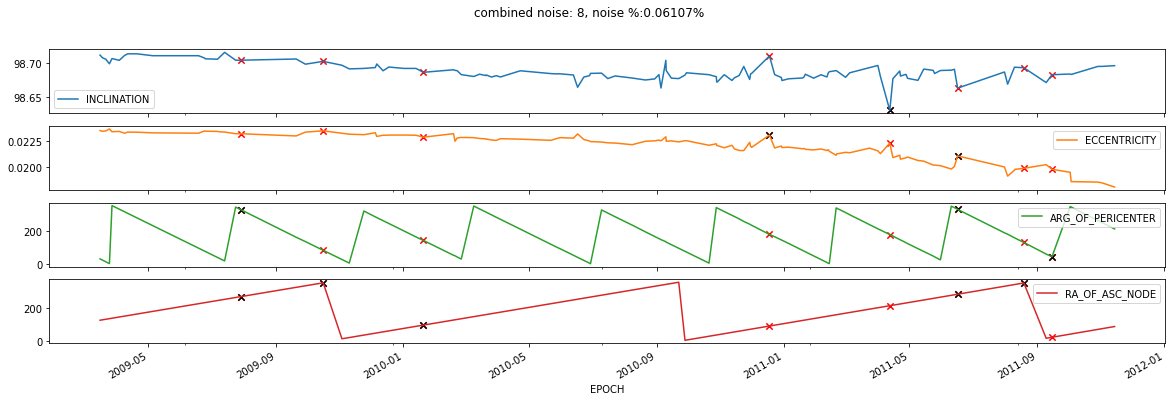

norad id: 34057, rows:5629
column: INCLINATION, n_clusters_: 1, n_noise_: 16, noise %:0.00284%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 15, noise %:0.00266%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 32, noise %:0.00568%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 27, noise %:0.00480%
norad id: 34057, rows:5629, combined noise count: 67, noise %:0.01190%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


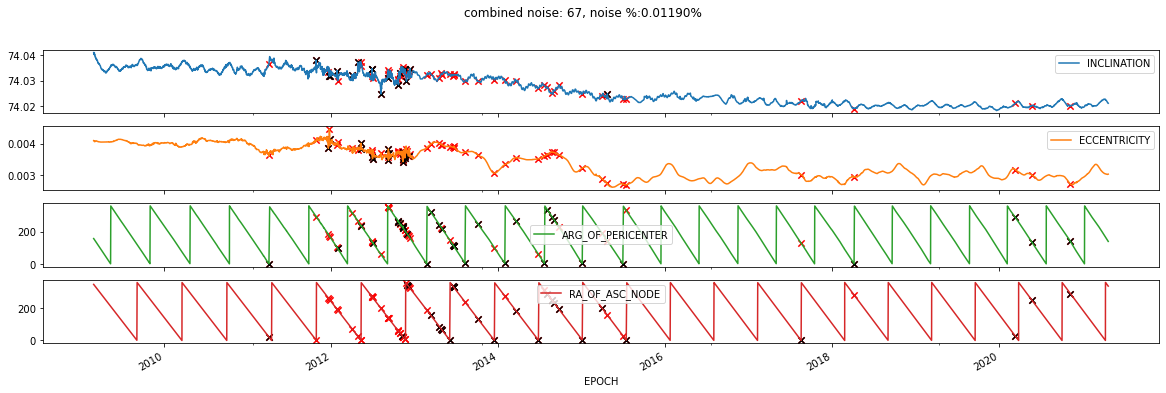

norad id: 34291, rows:2883
column: INCLINATION, n_clusters_: 1, n_noise_: 5, noise %:0.00173%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 4, noise %:0.00139%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 3, noise %:0.00104%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 2, noise %:0.00069%
norad id: 34291, rows:2883, combined noise count: 9, noise %:0.00312%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1]


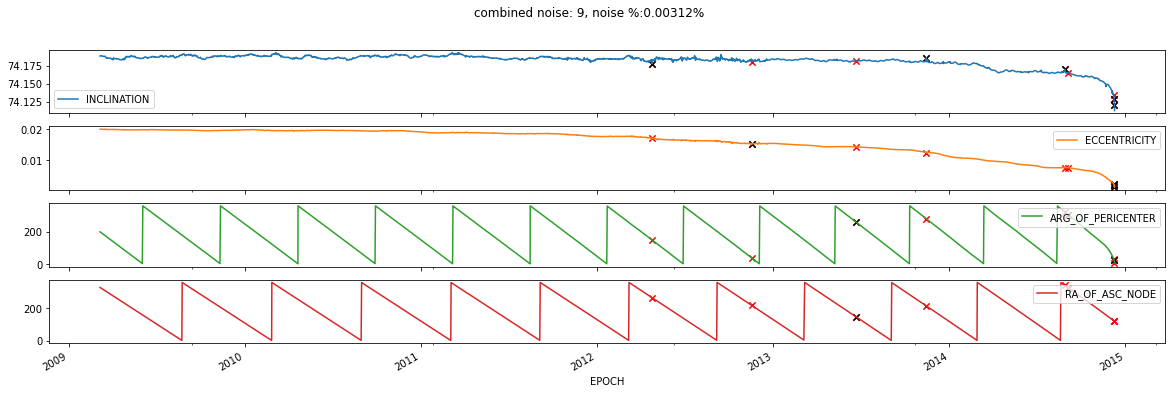

norad id: 34868, rows:3722
column: INCLINATION, n_clusters_: 1, n_noise_: 5, noise %:0.00134%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 11, noise %:0.00296%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 25, noise %:0.00672%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 20, noise %:0.00537%
norad id: 34868, rows:3722, combined noise count: 45, noise %:0.01209%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


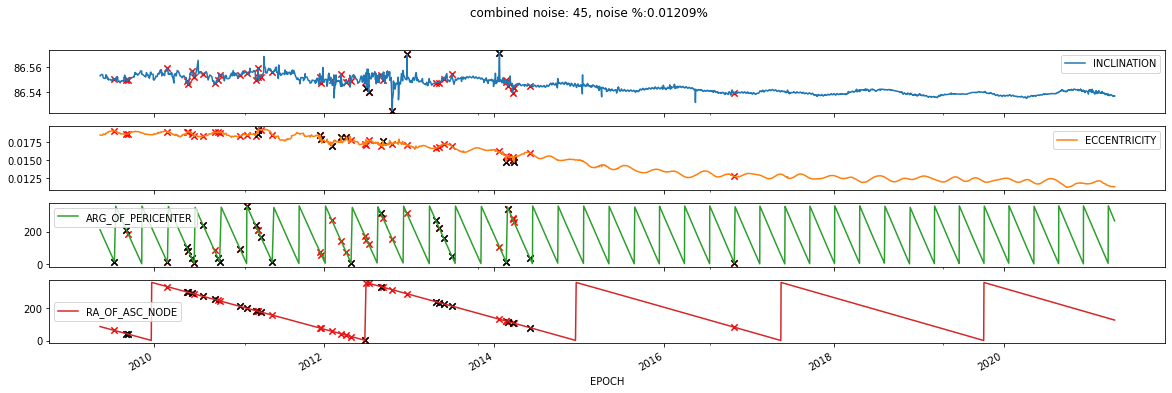

norad id: 35300, rows:796
column: INCLINATION, n_clusters_: 1, n_noise_: 3, noise %:0.00377%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 3, noise %:0.00377%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 15, noise %:0.01884%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 7, noise %:0.00879%
norad id: 35300, rows:796, combined noise count: 22, noise %:0.02764%
last 30 [1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 0 1 1 1 1]


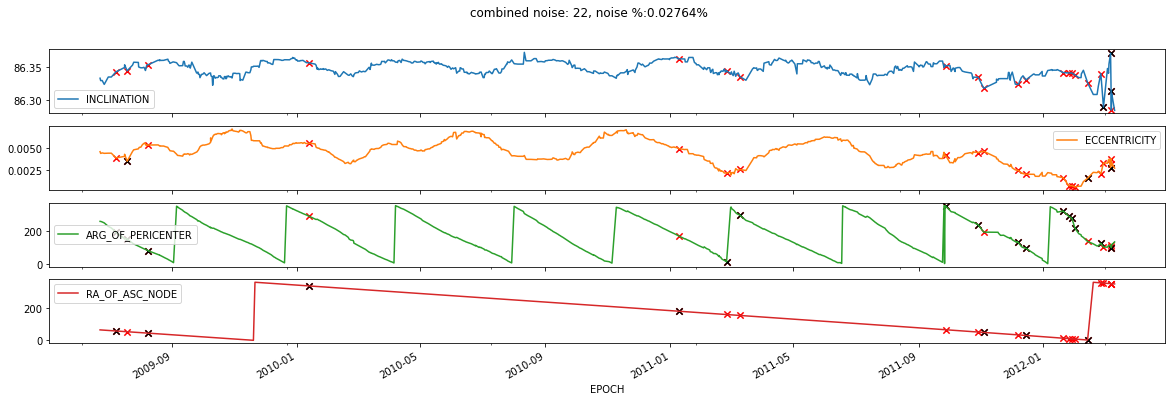

norad id: 35305, rows:556
column: INCLINATION, n_clusters_: 1, n_noise_: 2, noise %:0.00360%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 1, noise %:0.00180%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 5, noise %:0.00899%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 11, noise %:0.01978%
norad id: 35305, rows:556, combined noise count: 18, noise %:0.03237%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1]


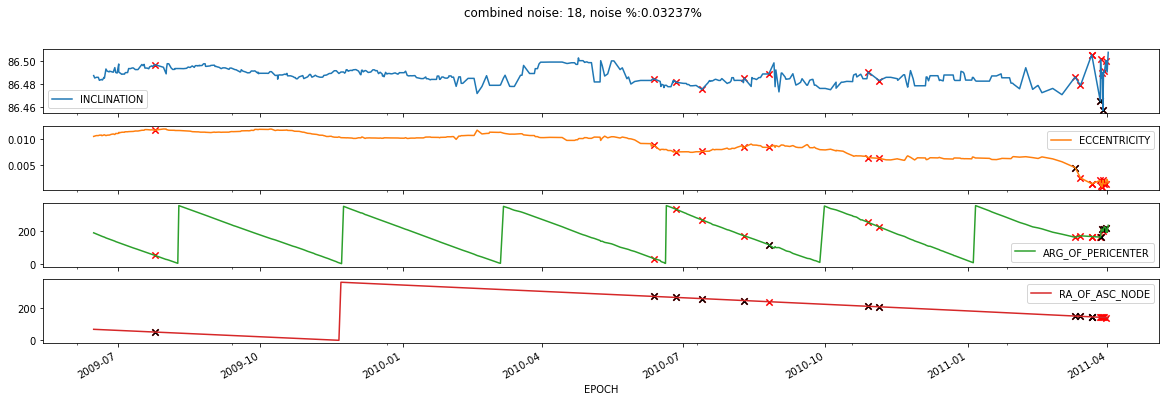

norad id: 36024, rows:864
column: INCLINATION, n_clusters_: 1, n_noise_: 1, noise %:0.00116%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 1, noise %:0.00116%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 11, noise %:0.01273%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 2, noise %:0.00231%
norad id: 36024, rows:864, combined noise count: 11, noise %:0.01273%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


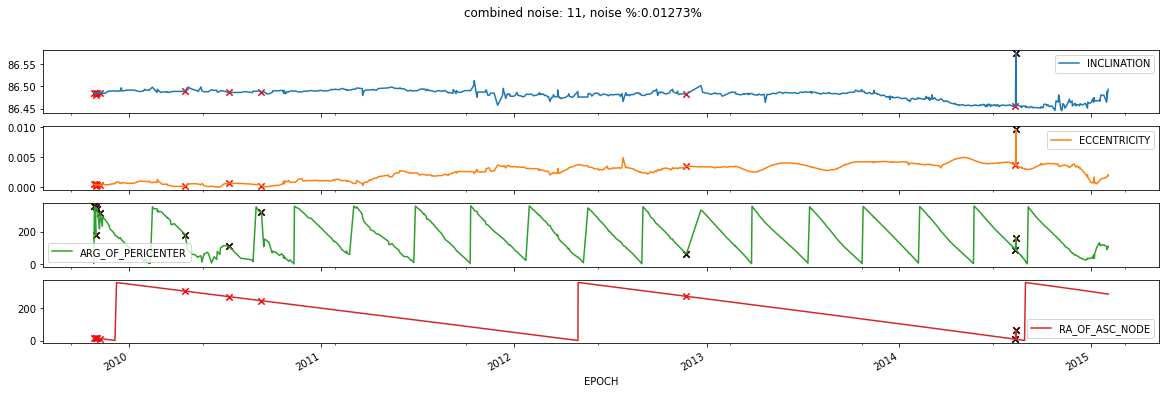

norad id: 39048, rows:331
column: INCLINATION, n_clusters_: 1, n_noise_: 1, noise %:0.00302%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 3, noise %:0.00906%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 6, noise %:0.01813%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 8, noise %:0.02417%
norad id: 39048, rows:331, combined noise count: 16, noise %:0.04834%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]


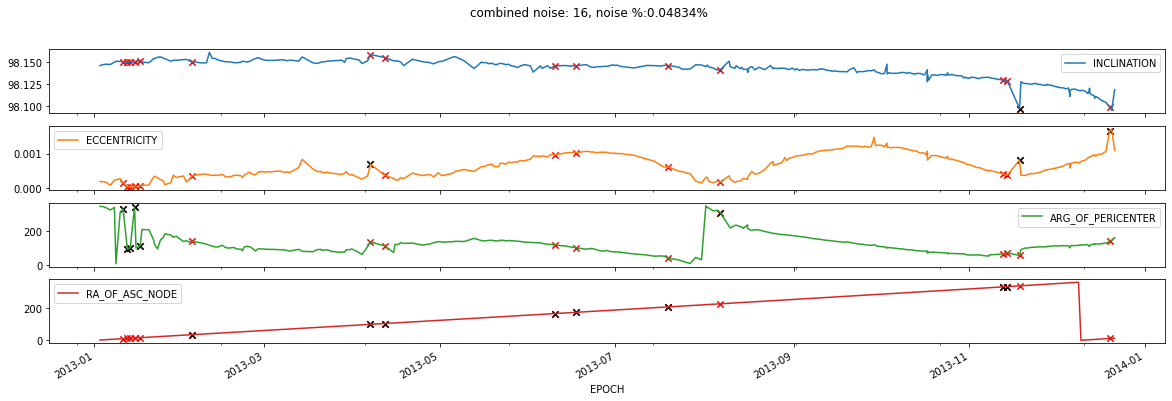

norad id: 40677, rows:762
column: INCLINATION, n_clusters_: 1, n_noise_: 1, noise %:0.00131%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 4, noise %:0.00525%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 8, noise %:0.01050%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 8, noise %:0.01050%
norad id: 40677, rows:762, combined noise count: 12, noise %:0.01575%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


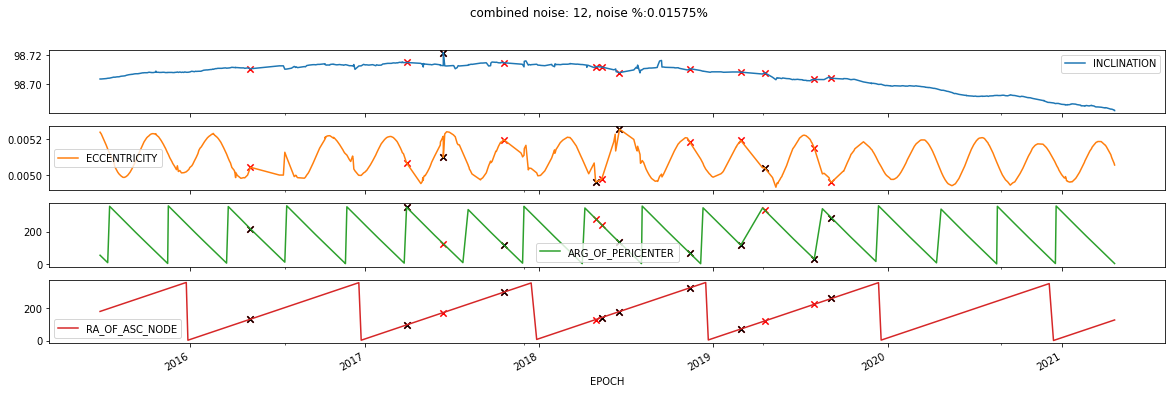

norad id: 41715, rows:1326
column: INCLINATION, n_clusters_: 1, n_noise_: 1, noise %:0.00075%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 2, noise %:0.00151%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 17, noise %:0.01282%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 15, noise %:0.01131%
norad id: 41715, rows:1326, combined noise count: 22, noise %:0.01659%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]


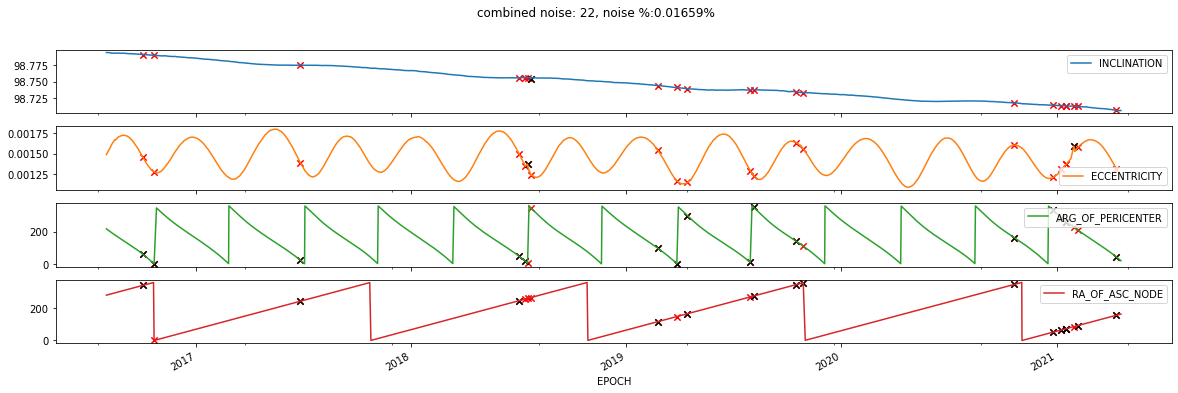

norad id: 43329, rows:2136
column: INCLINATION, n_clusters_: 1, n_noise_: 6, noise %:0.00281%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 2, noise %:0.00094%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 19, noise %:0.00890%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 14, noise %:0.00655%
norad id: 43329, rows:2136, combined noise count: 28, noise %:0.01311%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


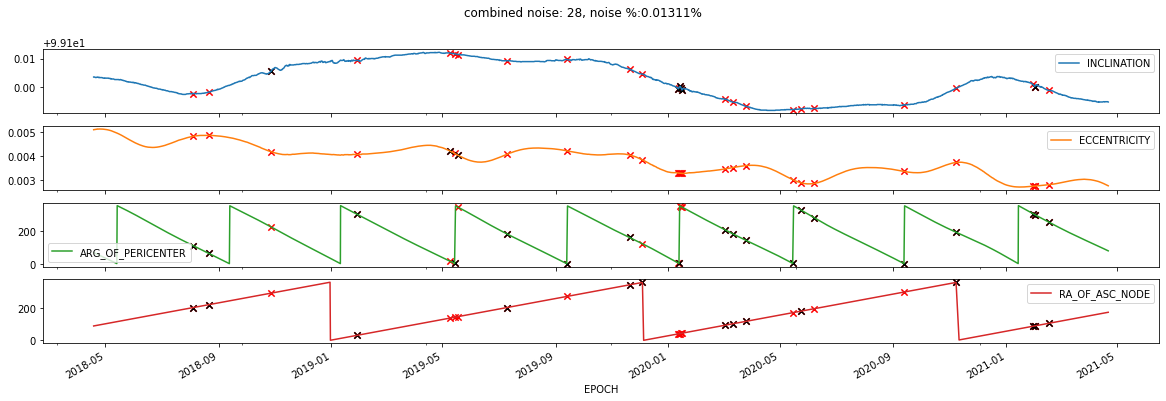

norad id: 47223, rows:325
column: INCLINATION, n_clusters_: 1, n_noise_: 2, noise %:0.00615%
column: ECCENTRICITY, n_clusters_: 1, n_noise_: 1, noise %:0.00308%
column: ARG_OF_PERICENTER, n_clusters_: 1, n_noise_: 10, noise %:0.03077%
column: RA_OF_ASC_NODE, n_clusters_: 1, n_noise_: 3, noise %:0.00923%
norad id: 47223, rows:325, combined noise count: 16, noise %:0.04923%
last 30 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


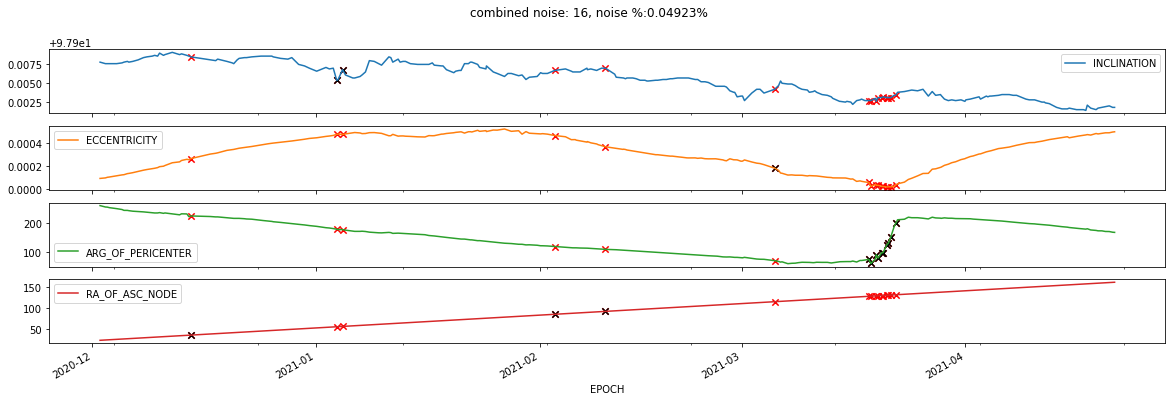

In [87]:
dbscan_eps_zero_neg = [] # this is to catch cases where std is negative(!!!?) or zero
dbscan_mask = dbscan_removal(masked_df, debug=True)

In [ ]:
# cases where std is negative or zero
# Seems to be satellites with only a single entry, safe to ignore

# dbscan_eps_zero_neg

In [ ]:
# final filtering of minimum entry count is needed? (not really because DBSCAN's min_samples)

In [ ]:
masked_df[dbscan_mask].groupby("NORAD_CAT_ID")['EPOCH'].count().describe()

# Save DataFrame with anomaly removed

`min` version is saved to `2_min` in the shared data folder.

In [ ]:
%%time
assert(False)
# save both masks
combined.to_pickle(f"{os.environ['GP_HIST_PATH']}/../2_min/anomaly_mask.pkl")
dbscan_mask.to_pickle(f"{os.environ['GP_HIST_PATH']}/../2_min/dbscan_mask.pkl")

# save min version
masked_df[dbscan_mask].to_pickle(f"{os.environ['GP_HIST_PATH']}/../2_min/train.pkl")

# We don't save full version anymore, since we no longer need the extra information
# # load
# train_df_full = pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../1_full/train.pkl")
# masked_df_full = train_df_full[combined]
# masked_df_full[dbscan_mask].to_pickle(f"{os.environ['GP_HIST_PATH']}/../2_full/train.pkl")

# del train_df_full, masked_df_full